<a href="https://colab.research.google.com/github/PGM-Lab/2022-ProbAI/blob/main/Day2-AfterLunch/notebooks/solutions_BBVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up Code

In [ ]:
# Standard imports. Nothing to install this time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Dict, List, Tuple, Union, Optional
from dataclasses import dataclass
from scipy.stats import multivariate_normal
import warnings

# Model and Data Generation

Let's define a way to generate data from a linear regression model:

$$ Y = 0.5 x + 1 +ϵ $$
$$ ϵ \sim N(0,0.1^2)$$

The true parameters generating the data are thus $\theta_0=1.0$ and $\theta_1=0.5$.

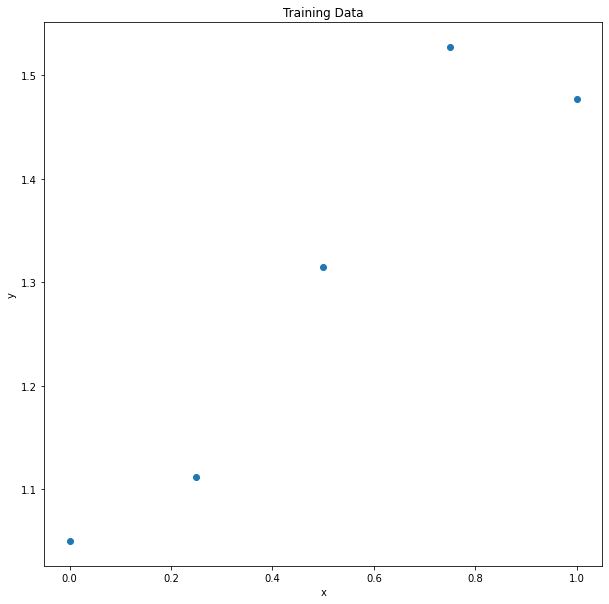

In [ ]:
#@title
def data_generator(offset: float, slope: float,
                   observation_noise: float,
                   no_samples: int = 10,
                   x_range: tuple = None,) -> Dict[str, np.ndarray]:
    """
    Data generator, sampling from the model y_i = offset + slope * x_i + eps_i,
    where eps_i is a Gaussian with mean 0 and a given noise-level.
    If x_range is given, x-values are evenly spread out in that area.
    If it is *not* given, we use [0, 1] as range
    :param offset: Offset for the regression model
    :param slope: Slope of the regression line
    :param observation_noise: Standard-deviation of the noise-term
    :param no_samples: Number of samples
    :param x_range: Range for x-values. x_i-values will be evenly spaced within range
    :return: a dict with two keys, 'x' and 'y'. Each corresponding value is a numpy array
    """
    x_range = (0, 1) if x_range is None else x_range
    x = np.linspace(start=x_range[0], stop=x_range[1], num=no_samples)
    y = offset + slope * x + np.random.randn(no_samples) * observation_noise
    return {'x': x, 'y': y}


# Generate data
np.random.seed(42)
no_observations = 5
data_noise = .1  # Model is y_i = w0 + w1*x + Normal(0, data_noise^2)
sample = data_generator(offset=1., slope=0.5, no_samples=no_observations, observation_noise=data_noise)

plt.title("Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(sample['x'], sample['y'])

# Computing $\ln p(D,\theta)$

Next, code for computing $\ln p(D,\theta)$ for a linear regression model:
$$\theta_j \sim N(0,10)  \text{ a priori for }j=1, 2$$
$$p(y|x,\theta_0,\theta_1) = N(\theta_0 x + \theta_1, 0.1^2)$$
Notice here that the parameters for $p(\theta)$ is defined using the `Parameters` data-plass, that means we get two slots of information: `prior.mean` and `prior.std`.

In [ ]:
#@title
#We define a "dataclass" to store distributional parameters for a Gaussian. 
# The class expects one vector for the mean, andother for the standard deviation. 
# We will use it for 2D distributions, but hard-code that the two components are independent (as the standard deviations only define the diagonal of the covariance matrix). 
@dataclass
class Parameters:
    mean: np.ndarray    # Mean of some 2-variable Gaussian distribution. A numpy-vector of size (2,)
    std: np.ndarray     # Standard deviations of some 2-variable Gaussian distribution. A numpy-vector of size (2,)

In [ ]:
def log_p(data: dict,
          theta: np.ndarray,
          prior: Parameters,
          observation_noise: float) -> Union[float, np.ndarray]:
    """
    Calculate log p(data , theta)
    :param observation_noise: Noise in regression model
    :param data: Dict with data. Keys are 'x' and 'y'
    :param theta: Values for theta: theta[0] is offset, theta[1] is slope
    :param prior: Parameters describing the prior distribution
    :return: log probability of data and theta
    """

    # Here we do some extras to make sure that we can take in many thetas at the time (needed for contour plots)
    if len(theta.shape) == 1:
        theta = np.reshape(theta, (1, -1))

    # Log prior, i.e., log p(theta) under the prior distribution. Outsource this to scipy's multivariate
    log_prior_probs = multivariate_normal(mean=prior.mean, cov=prior.std**2).logpdf(theta)

    # Some extra efforts here for vectorization of the code needed for the plotting procedure to be efficient
    locs = np.reshape(theta[:, 0], (-1, 1)) + np.reshape(data['x'], (1, -1)) * np.reshape(theta[:, 1], (-1, 1))
    log_likelihoods = np.sum(norm(loc=locs, scale=observation_noise).logpdf(
        np.reshape(data['y'], (1, -1))), axis=-1)

    # We need the sum: log p(theta) + log p( data | theta)
    return_value = log_prior_probs + log_likelihoods

    # Squeeze if possible -- again due to the vectorization of the code
    if return_value.size == 1:
        return_value = float(return_value[0])

    # We are done.
    return return_value

# Computing  $\ln q(\theta|\lambda)$

In our case, we have **two parameters** $\theta=(\theta_0,\theta_1)$ and the **variational family** $q(\theta|\lambda)$ can be expressed as:

$$q(\theta|\lambda) = q_0(\theta_0|\mu_0,\sigma_0)q_1(\theta_1|\mu_1,\sigma_1)$$

$$q_i(\theta_i|\mu_i,\sigma_i) = N(\theta_i|\mu_i,\sigma_i)\quad i=0,1$$

In [ ]:
def log_q(theta: np.ndarray,
          q_distribution: Parameters,
          ) -> Union[float, np.ndarray]:
    """
    Calculate log q(theta | lambda)
    :param theta: Parameters for theta: theta[0] is offset, theta[1] is slope
    :param q_distribution: Lambda-parameters. Position[0] is for offset, Position [1] is for slope, 
    so q_distribution.mean[0] is the expected value E_q[theta_0], etc.
    :return: Log variational probability of theta under q(theta|lambda)
    """

    # Here we do some extras to make sure that we can take in many thetas at the time (needed for contour plots)
    if len(theta.shape) == 1:
        theta = np.reshape(theta, (1, -1))

    return_value = multivariate_normal(mean=q_distribution.mean, cov=q_distribution.std**2).logpdf(theta)

    # Squeeze if possible
    if isinstance(return_value, np.ndarray) and return_value.size == 1:
        return_value = float(return_value[0])

    return return_value

# Computing the ELBO

Calculation of the ELBO for linear regression. This implementation is not altered by us doing gradient-based ELBO. It is included simply for plotting and monitoring convergence.

In [ ]:
def calculate_evidence_lower_bound(
        data: Dict[str, np.ndarray],
        q_distribution: Parameters,
        prior: Parameters,
        observation_noise: float
):
    """
    Helper routine: Calculate ELBO.
    Note: This function obviously only works for this particular model and is not a general solution.

    :param data: Data is the sampled x and y values in a dictionary
    :param q_distribution: Representation for the variational distribution
    :param prior: Prior distribution p(theta)
    :param observation_noise:  The data noise for y
    :return: The calculated ELBO
    """

    # We calculate the ELBO as E_q log p(data, theta) - E_q log q(theta), where
    # log log p(data, theta) = sum_i log p(y_i|x_i,theta) + log p(theta_0) + log p(theta_1)
    # log q(theta) = log q(theta_0) + log q(theta_2)

    # E_q log p(theta_j) = -0.5 * log(2 * np.pi) - log(prior sigma) - E_q [theta_j**2] / (2*prior_sigma^2)
    expected_log_p = \
        - .5 * np.log(2 * np.pi) \
        - .5 * np.log(prior.std[0])  \
        - .5 * (q_distribution.mean[0] ** 2 + q_distribution.std[0] ** 2) / (prior.std[0] ** 2)
    expected_log_p += \
        - .5 * np.log(2 * np.pi) \
        - .5 * np.log(prior.std[1]) \
        - .5 * (q_distribution.mean[1] ** 2 + q_distribution.std[1] ** 2) / (prior.std[1] ** 2)

    # E_q log p(y_i|x,theta)
    expected_theta_squared = q_distribution.mean ** 2 + q_distribution.std ** 2
    for i in range(data['x'].shape[0]):
        x_i, y_i = data['x'][i], data['y'][i]
        expected_log_p += -0.5 * np.log(2 * np.pi) - 0.5 * np.log(observation_noise) \
                          - 0.5/(observation_noise**2) * (
                                  y_i ** 2
                                  - 2 * y_i * q_distribution.mean[0]
                                  - 2 * y_i * x_i * q_distribution.mean[1]
                                  + expected_theta_squared[0]
                                  + expected_theta_squared[0]
                                  + x_i ** 2 * expected_theta_squared[1]
                                  + 2 * q_distribution.mean[0] * q_distribution.mean[1]
                          )
    # Entropy of q
    ent = multivariate_normal(mean=q_distribution.mean, cov=q_distribution.std**2).entropy()
    return expected_log_p - ent


# Auxiliary Code

The `GradientInfo` dataclass is used to store gradient information. The main slot is `gradient`, which will hold the gradient value. Since we have gradient for all parameters in $\boldsymbol\lambda$, we again use a `Parameters` dataclass to keep hold of the numerical quantities. 

In [ ]:
#@title
@dataclass
class GradientInfo:
    theta: np.ndarray
    score_function: Optional[Parameters]
    gradient: Parameters
    aggregation: bool

We use `estimate_gradient_by_sampling` to generate the gradient estimate: Run through generating a number of samples, and average it. A bit of extras for making nice plots

In [ ]:
#@title
def estimate_gradient_by_sampling(
        data: Dict[str, np.ndarray],
        q_distribution: Parameters,
        prior: Parameters,
        observation_noise: float,
        gradient_estimator: callable,
        no_samples: int = 1
) -> Tuple[Parameters, List[GradientInfo]]:
    
    """
    Run the gradient estimation. A number of gradient estimates are found, and averaged. 
    
    :param data: The data. A dict with two keys: 'x' and 'y'
    :param q_distribution:  The parameters ofbthe q-distribution
    :param prior: The parameters of the prior
    :param observation_noise: The observation noise in the likelihood model 
    :param gradient_estimator: The callable used to generate a sample-point with associated gradient
    :param no_samples: The number of samples to make and average over in the estimate. Called $M$ in the slides
    :return: First a Parameter-object with the gradient, ten a list of GradienTino-s. 
        The latter is only used for plotting
    """

    # aggregated: Data sotrage that keeps track of the sum of individual gradient as we move on
    aggregated = Parameters(mean=np.array([0., 0.]), std=np.zeros((2, )))
    
    # parts: a list to keep track of the gradient-information from each of the samples. 
    parts = []

    for _ in range(no_samples):

        # Find gradient at a random location. What this means is outsorced to the 
        # gradient_estimator callable
        sampled_gradient = gradient_estimator(
            data=data,
            q_distribution=q_distribution,
            observation_noise=observation_noise,
            prior=prior,
        )
        # Add up
        aggregated.mean += sampled_gradient.gradient.mean
        aggregated.std += sampled_gradient.gradient.std
        parts += [sampled_gradient]

    # Aggregated is average move, not sum of moves as so far
    aggregated.mean /= no_samples
    aggregated.std /= no_samples
    
    # Remember the gradient information, too
    parts += [
        GradientInfo(
            gradient=aggregated,
            aggregation=True,
            score_function=None,
            theta=q_distribution.mean)
    ]
    
    # Done
    return aggregated, parts


The next function is only for plotting contour plots and gradient estimators. 

In [ ]:
#@title
def plot_pdfs(q_distribution: Parameters,
              prior: Parameters,
              observation_noise: float,
              data: Dict[str, np.ndarray],
              title: str = None,
              arrows: List[GradientInfo] = None,
              filename: str = None) -> None:

    
    
    
    # Find some range for parameters, and make ranges for w0, w1

    # Fairly zoomed in
    w0_list = np.linspace(0., 2., 100)
    w1_list = np.linspace(0., 1., 100)

    # Bird's eye view
    # w0_list = np.linspace(-3, 6., 100)
    # w1_list = np.linspace(-1., 3., 100)

    w0_mesh, w1_mesh = np.meshgrid(w0_list, w1_list)

    plt.Figure()
    plt.rcParams["figure.figsize"] = (10,10)

    ax = plt.gca()

    arrows = [] if arrows is None else arrows

    for arrow in arrows:
        plt.arrow(
            x=arrow.theta[0],
            y=arrow.theta[1],
            dx=arrow.gradient.mean[0] * 1E-3,
            dy=arrow.gradient.mean[1] * 1E-3,
            length_includes_head=True,
            color='g' if arrow.aggregation else 'k'
        )
        if arrow.score_function is not None:
            plt.arrow(
                x=arrow.theta[0],
                y=arrow.theta[1],
                dx=arrow.score_function.mean[0] * 1E-3,
                dy=arrow.score_function.mean[1] * 1E-3,
                length_includes_head=True,
                color="r"
            )

        plt.plot(
            arrow.theta[0],
            arrow.theta[1],
            f"{'g' if arrow.aggregation else 'k'}o",
            markersize=3.
        )



    # Plot p(theta|Data). Note, since we use contours here, and p(Data) is constant in theta, we
    # plot p(theta, data) instead -- won't make a difference and easier since it is already available
    theta_vector = np.vstack([w0_mesh.flatten(), w1_mesh.flatten()]).T
    ax.contour(
        w0_mesh,
        w1_mesh,
        np.exp(log_p(
            data=data,
            theta=theta_vector,
            prior=prior,
            observation_noise=observation_noise
        )).reshape(w0_mesh.shape),
        colors='b',
        linewidths=.5,
        linestyles='dashed',
        levels=5,
        alpha=1.
    )

    # Plot log-q
    ax.contour(
        w0_mesh,
        w1_mesh,
        np.exp(log_q(
            q_distribution=q_distribution,
            theta=theta_vector,
        )).reshape(w0_mesh.shape),
        colors='g',
        linewidths=1.,
        linestyles='dashed',
        levels=5,
        alpha=1.
    )

    # Fix the layout
    plt.xlim([w0_list[0], w0_list[-1]])
    plt.ylim([w1_list[0], w1_list[-1]])
    plt.grid(True, which='both')
    plt.xlabel('$\\theta_0$')
    plt.ylabel('$\\theta_1$')
    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

    plt.show()



We use `compute_gradients` to run the show: Initiallize $q$ at a suitable location, then do the learning iteratively. It will update the results it moves along, and even dump some plots every now and then. 

In [ ]:
#@title
store_elbo = {}

def compute_gradients(gradient_method: dict, 
                      no_samples_per_iter: int = 5, 
                      learning_rate: float = 0.0001, 
                      no_iter: int = 1000) -> None:
    
    """
    The main entry point for testing a gradient-based method. Implements a 
        naive (fixed-learning-rate) optimizer.
    
    :param gradient_method: A dictionary containing two keys: 
        'name' that gives the name of the method, and 
        'callable', that gives the callable that calculates gradients
    
    :param no_samples_per_iter: The number of samples used to approximate 
        the expectation by sampling. Called M in the slides
    :param learning_rate: The learning rate. 
    :param no:iter: The number of iterations
    """

    # Define our weight prior
    prior_weight_sigma = 10.
    prior_distribution = Parameters(
        mean=np.array([0, 0]),
        std=np.array([prior_weight_sigma, prior_weight_sigma])
    )

    # Define starting-point for the variational iterations
    variational_distribution = Parameters(
        mean=np.array([0., 0.]),
        std=np.array([prior_weight_sigma, prior_weight_sigma])
    )

    # Set aside some storage for ELBOs obtained by the method
    store_elbo[gradient_method['name']] = np.empty((no_iter,))

    for iteration in range(no_iter):
        # Calculate the score gradient.
        # The gradient-function returns to things: The actual gradient (a Parameters-typed object),
        # and a list of GradientInfo objects. The latter is for plotting only
        grad, plot_arrows = estimate_gradient_by_sampling(
            gradient_estimator=gradient_method['callable'],
            data=sample,
            q_distribution=variational_distribution,
            prior=prior_distribution,
            observation_noise=data_noise,
            no_samples=no_samples_per_iter
        )

        # Plotting
        if (iteration + 1) % 50 == 0:
            plot_pdfs(
                q_distribution=variational_distribution,
                data=sample,
                prior=prior_distribution,
                observation_noise=data_noise,
                arrows=plot_arrows,
                title=f"{gradient_method['name']} -- Iteration {iteration + 1}",
                filename=f"iteration{iteration + 1}_{gradient_method['name']}.pdf"
            )
        variational_distribution.mean += grad.mean * learning_rate
        variational_distribution.std += grad.std * learning_rate

        # Take some care: With very noisy gradients (small M), too large learning rate,
        # and no fancy re-parameterization of the standard deviation in q, this vanilla
        # version can run into settings where the estimated standard deviations get negative.
        # If this happens we simply undo the move, and hope for a better sample the next time...
        if np.min(variational_distribution.std) < 1E-3:
            variational_distribution.mean -= grad.mean * learning_rate
            variational_distribution.std -= grad.std * learning_rate
            warnings.warn(
                f"\nHad to undo move in iteration {iteration + 1}:\n"
                f"\t- Learning rate: {learning_rate}\n"
                f"\t- M = {no_samples_per_iter}\n"
                f"\t- Gradient lengths {np.linalg.norm(grad.mean):.2f} (mean) and "
                f"{np.linalg.norm(grad.std):.2f} (std).\n"
                f"\t- Current lambda: {variational_distribution.mean} (mean) and "
                f"{variational_distribution.std} (std).\n"
                f"Anyway. No harm done -- will just keep on going!"
            )

        # Calculate ELBO and store it for later plotting
        store_elbo[gradient_method['name']][iteration] = \
            calculate_evidence_lower_bound(
                data=sample,
                q_distribution=variational_distribution,
                observation_noise=data_noise,
                prior=prior_distribution,
            )
        
        # Dump some info
        if (iteration + 1) % 50 == 0:
          print(f"{gradient_method['name']} -- Iteration {iteration + 1:6d} / {no_iter}, M = {no_samples_per_iter}: "
                f"q is N({variational_distribution.mean[0]:6.3f}, {variational_distribution.std[0]:6.3f}) and "
                f"N({variational_distribution.mean[1]:6.3f}, {variational_distribution.std[1]:6.3f}) -> "
                f"ELBO = {store_elbo[gradient_method['name']][iteration]:15.4f}")

# Exercise 1. Score Function Gradients

* In this first exercise, we ask you to implement a key part of the score function method to compute gradients. As we showed in Slide 8, the score function method computes the gradient of the ELBO in the following way:

$$\nabla_\lambda {\cal L} (\lambda)= \frac{1}{M} \sum_{j}^M \ln \frac{p(D,\theta^{(j)})}{q(\theta^{(j)}|\lambda)}∇_λ \ln q(\theta^{(j)}|\lambda)$$
where $\theta^{(j)} \sim q(\theta|\lambda)$. 

* Remember, we have a **linear regression model**
$$\theta_0, \theta_1 \sim N(0,10)$$
$$y|x,\theta_0,\theta_1 \sim N(\theta_0 x + \theta_1, 0.1)$$

* In our case, we have **two parameters** $\theta=(\theta_0,\theta_1)$ and the **variational family** $q(\theta|\lambda)$ can be expressed as:

$$q(\theta|\lambda) = q_0(\theta_0|\mu_0,\sigma_0)q_1(\theta_1|\mu_1,\sigma_1)$$

$$q_i(\theta_i|\mu_i,\sigma_i) = N(\theta_i|\mu_i,\sigma_i)\quad i=0,1$$

For your reference, 
$$\log q_i(\mu_i, \sigma_i) = -1/2\log(2\pi)-\log\sigma - \frac{1}{2\sigma^2}(θ_i-\mu_i)^2$$


* **For a given sample $\theta$ from $q(\theta|\lambda)$**, we have to:



> 1. **Compute its associated weight** (this is coded below): 
$$\ln \frac{p(D,\theta)}{q(\theta|\lambda)} = \ln p(D,\theta) - \ln q(\theta|\lambda)$$ 

> 2. **Compute the gradient** of $\ln q(\theta|\lambda)$ (i.e. $∇_λ \ln q(\theta|\lambda$). 

We now ask you to derive and these gradient for the linear regression model. This requires both $∇_{\mu_i}\ln q_i(\theta_i|\mu_i,\sigma_i)$ and $∇_{\sigma_i}\ln q_i(\theta_i|\mu_i,\sigma_i)$, but to help you get going we give the result wrt. $\sigma$:


$$∇_{\sigma_i}\ln q_i(\theta_i|\mu_i,\sigma_i) = \frac{(\theta_i-\mu_i)^2}{\sigma_i^3} - \frac{1}{\sigma}\quad i=0,1$$

$$∇_{\mu_i}\ln q_i(\theta_i|\mu_i,\sigma_i) = \frac{(\theta_i-\mu_i)}{\sigma_i^2}\quad i=0,1$$

**TASK FOR THIS EXERCISE:** Find the gradient with respect to $\mu$, and implement it. Test the solution in the cells below.


In [ ]:
def score_function_gradient(
        q_distribution: Parameters,
        prior: Parameters,
        observation_noise: float,
        data: Dict[str, np.ndarray],
) -> GradientInfo:

    """
    Sample a theta, and find gradient at that theta defined as
         (log p(d, theta) - log q(theta|lambda)) * gradient_lambda log q(theta|lambda)
         
    :param q_distribution: Parameters for the q-distribution
    :param prior: Parameters for the prior distribution
    :param observation_noise: The observation noise in the regression model
    :param data: A dictionary with the data. Has two keys: 'x' and 'y'
    :return: The gradient info. 
    
    """
    # Sample a location
    theta_sample = multivariate_normal(mean=q_distribution.mean, cov=q_distribution.std ** 2).rvs(size=1)

    # Weight is log p(d, theta) - log q(theta|lambda). We have functions to calculate each part
    weight = log_p(data=data, theta=theta_sample, prior=prior, observation_noise=observation_noise) - \
             log_q(theta=theta_sample, q_distribution=q_distribution)


    # for mu the score function is (theta - mu)/sigma^2 -- holds for each dimension
    # for sigma the score function is  1/sigma * [(theta - mu)**2/sigma**2 - 1] -- holds for each dimension
    score_function = Parameters(
        mean=np.array([
            (theta_sample[0] - q_distribution.mean[0]) / q_distribution.std[0]**2,
            (theta_sample[1] - q_distribution.mean[1]) / q_distribution.std[1]**2
        ]),
        
        std=np.array([
            (((theta_sample[0] - q_distribution.mean[0]) / q_distribution.std[0])**2 - 1) / q_distribution.std[0],
            (((theta_sample[1] - q_distribution.mean[1]) / q_distribution.std[1]) ** 2 - 1) / q_distribution.std[1]
        ])
    )

    # Gradients are score-function times the weights calculated above
    gradient = Parameters(
        mean=weight * score_function.mean,
        std=weight * score_function.std
    )

    # Package everything so that we have plotting information as well as the answer
    solution = GradientInfo(
        theta=theta_sample,
        score_function=score_function,
        gradient=gradient,
        aggregation=False
    )

    # Done!
    return solution


As soon as the gradients are calculated correctly we can package a dict to contain information about it and run `compute_gradients`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 21:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 25531.85 (mean) and 85946.04 (std).
	- Current lambda: [1.66668534 0.10053715] (mean) and [7.03141832 6.94954666] (std).
Anyway. No harm done -- will just keep on going!


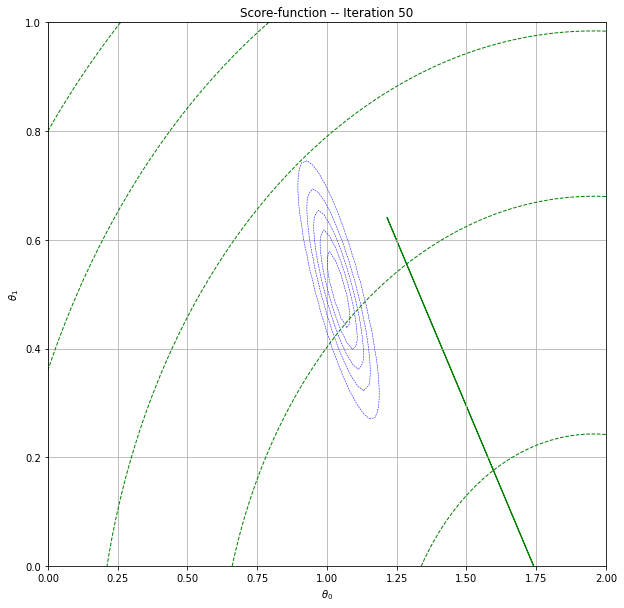

Score-function -- Iteration     50 / 1000, M = 5: q is N( 1.882,  3.515) and N(-0.172,  2.491) -> ELBO =      -7649.3651


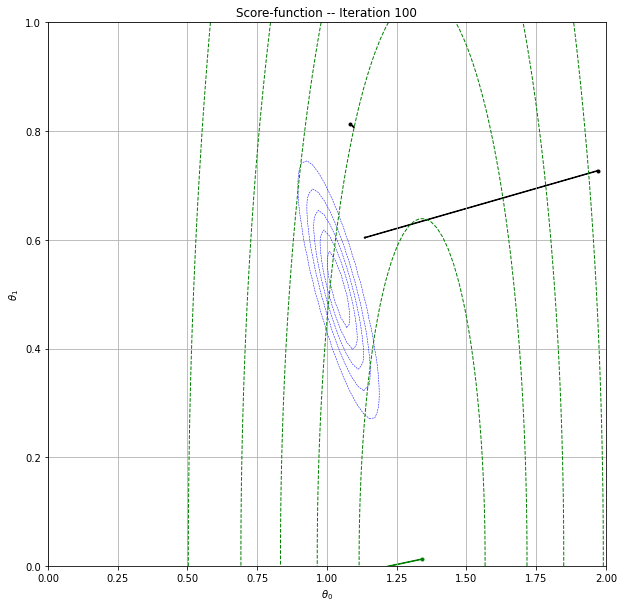

Score-function -- Iteration    100 / 1000, M = 5: q is N( 1.312,  0.432) and N( 0.010,  1.254) -> ELBO =       -687.9283


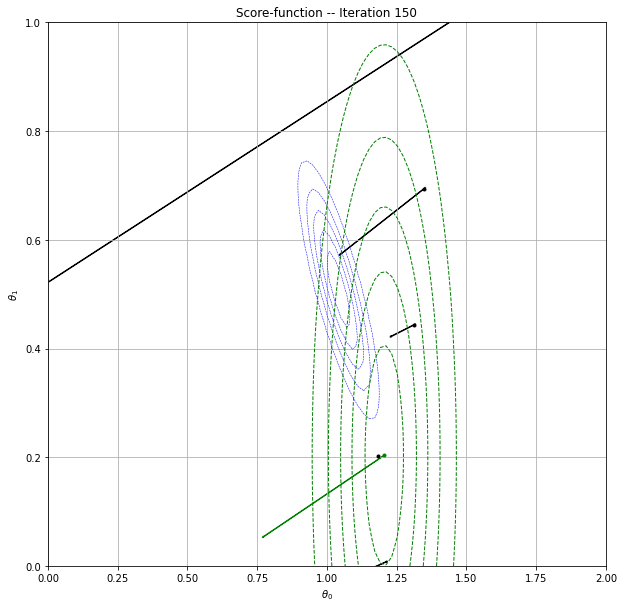

Score-function -- Iteration    150 / 1000, M = 5: q is N( 1.162,  0.080) and N( 0.188,  0.387) -> ELBO =       -416.3588


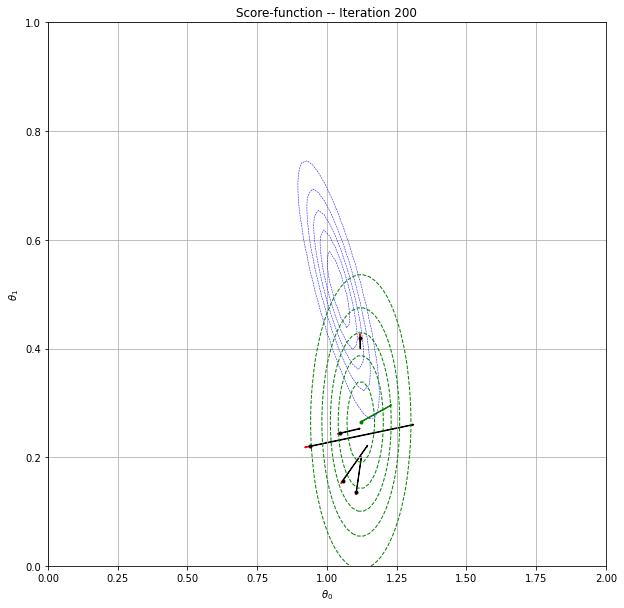

Score-function -- Iteration    200 / 1000, M = 5: q is N( 1.133,  0.091) and N( 0.268,  0.150) -> ELBO =       -407.3459


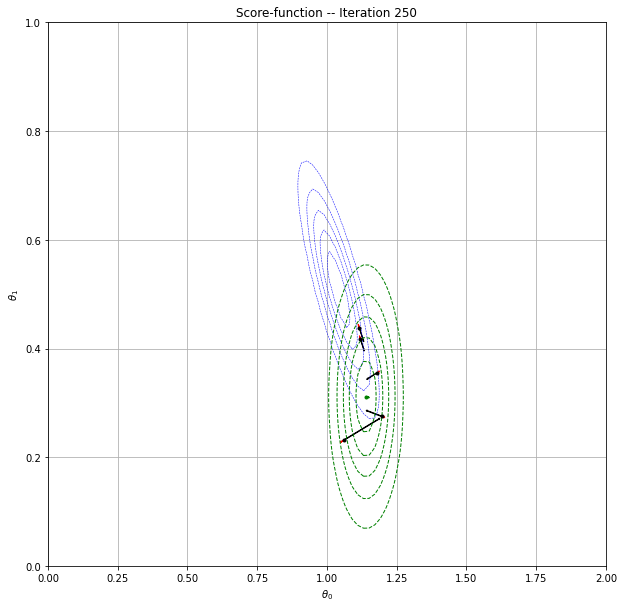

Score-function -- Iteration    250 / 1000, M = 5: q is N( 1.142,  0.074) and N( 0.311,  0.132) -> ELBO =       -422.5046


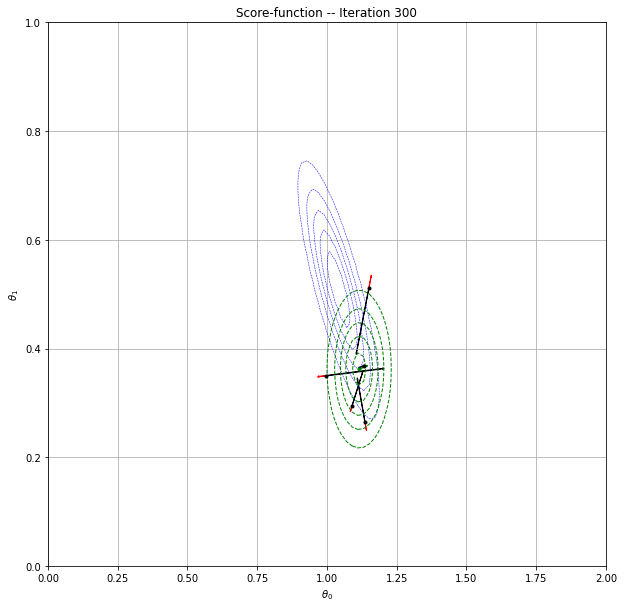

Score-function -- Iteration    300 / 1000, M = 5: q is N( 1.119,  0.062) and N( 0.363,  0.078) -> ELBO =       -419.2380


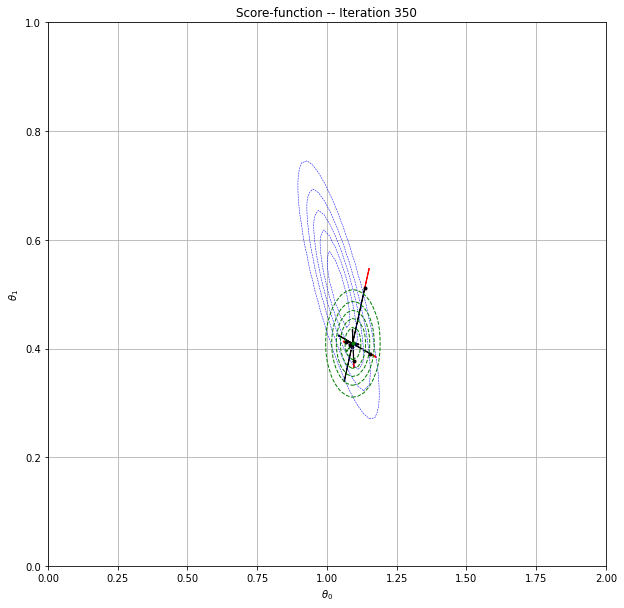

Score-function -- Iteration    350 / 1000, M = 5: q is N( 1.091,  0.057) and N( 0.408,  0.054) -> ELBO =       -412.1451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 399:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 184.91 (mean) and 514.46 (std).
	- Current lambda: [1.07262756 0.4203253 ] (mean) and [0.01561606 0.07897856] (std).
Anyway. No harm done -- will just keep on going!


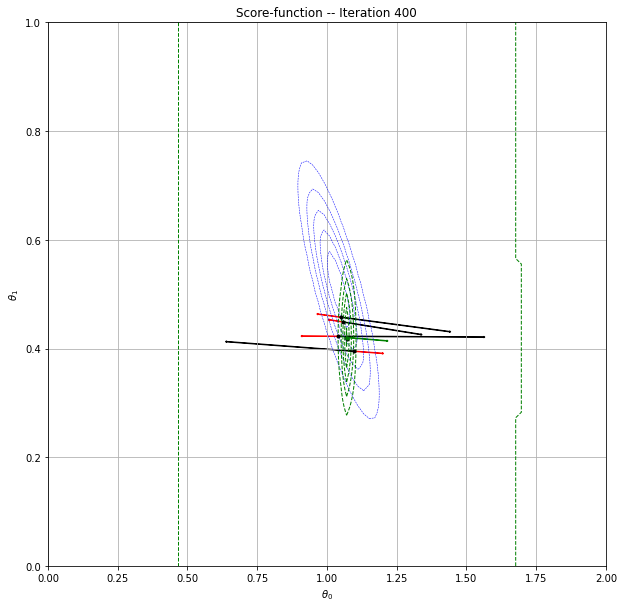

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 400:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 146.67 (mean) and 230.55 (std).
	- Current lambda: [1.07262756 0.4203253 ] (mean) and [0.01561606 0.07897856] (std).
Anyway. No harm done -- will just keep on going!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 403:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 206.45 (mean) and 208.51 (std).
	- Current lambda: [1.10268019 0.42344134] (mean) and [0.00464147 0.0821253 ] (std).
Anyway. No harm done -- will just keep on going!


Score-function -- Iteration    400 / 1000, M = 5: q is N( 1.073,  0.016) and N( 0.420,  0.079) -> ELBO =       -401.4618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 424:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 71.72 (mean) and 275.20 (std).
	- Current lambda: [1.10125572 0.45369697] (mean) and [0.00857633 0.06515144] (std).
Anyway. No harm done -- will just keep on going!


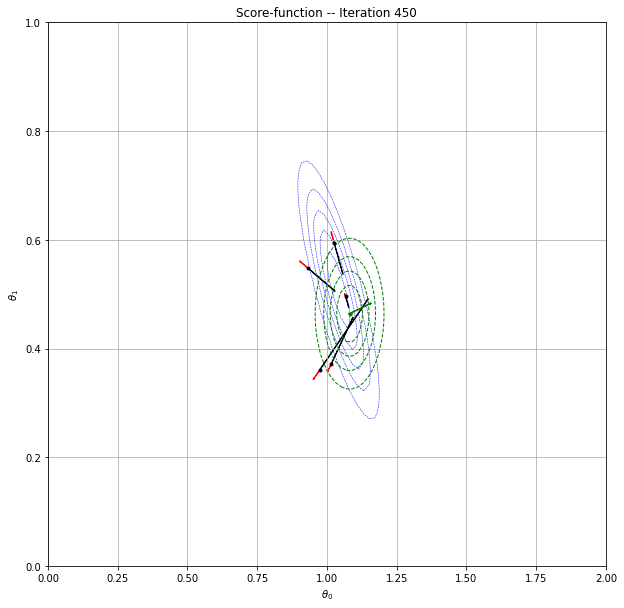

Score-function -- Iteration    450 / 1000, M = 5: q is N( 1.089,  0.063) and N( 0.466,  0.074) -> ELBO =       -427.7491


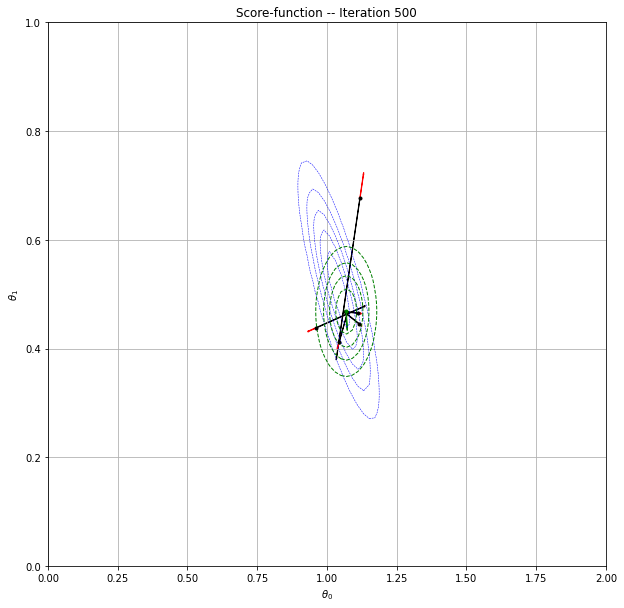

Score-function -- Iteration    500 / 1000, M = 5: q is N( 1.070,  0.060) and N( 0.465,  0.055) -> ELBO =       -413.7056


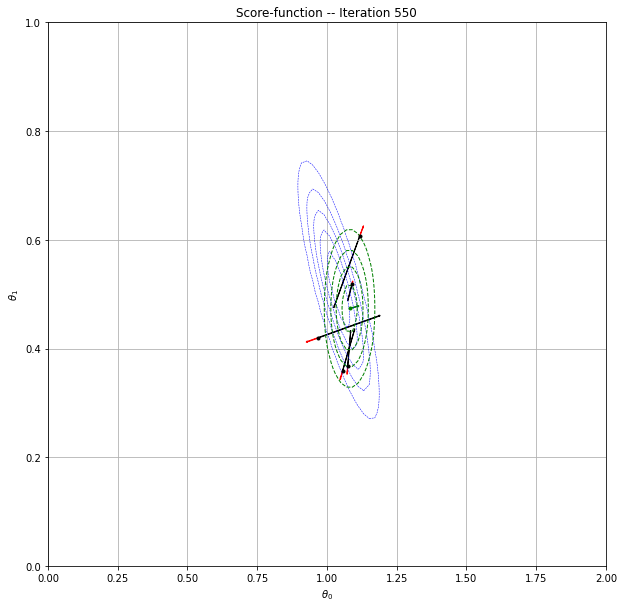

Score-function -- Iteration    550 / 1000, M = 5: q is N( 1.085,  0.050) and N( 0.474,  0.080) -> ELBO =       -426.1702


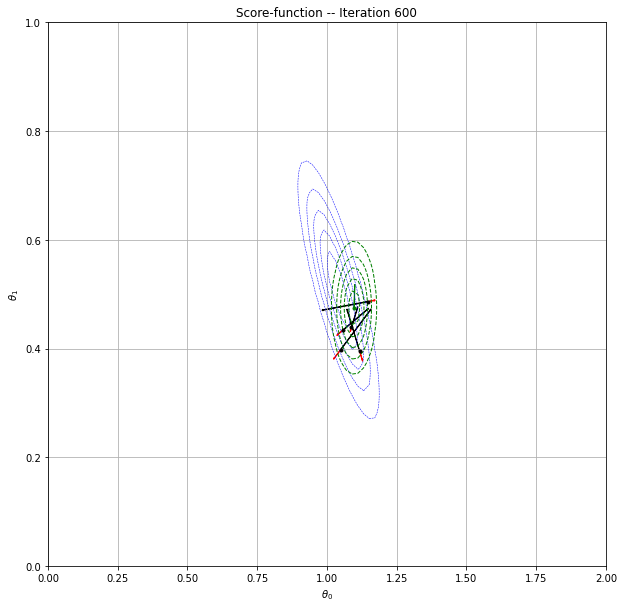

Score-function -- Iteration    600 / 1000, M = 5: q is N( 1.098,  0.045) and N( 0.479,  0.068) -> ELBO =       -435.7362


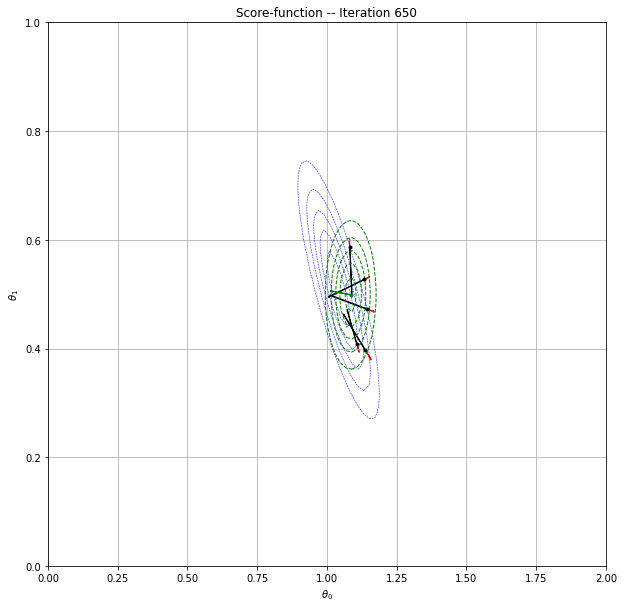

Score-function -- Iteration    650 / 1000, M = 5: q is N( 1.078,  0.051) and N( 0.500,  0.075) -> ELBO =       -428.5199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 677:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 61.48 (mean) and 431.81 (std).
	- Current lambda: [1.07416568 0.47955402] (mean) and [0.01483924 0.06432448] (std).
Anyway. No harm done -- will just keep on going!


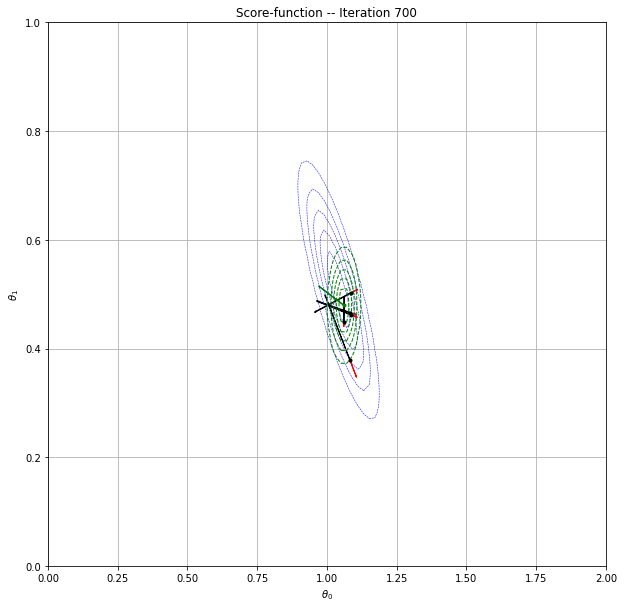

Score-function -- Iteration    700 / 1000, M = 5: q is N( 1.052,  0.039) and N( 0.483,  0.060) -> ELBO =       -405.6899


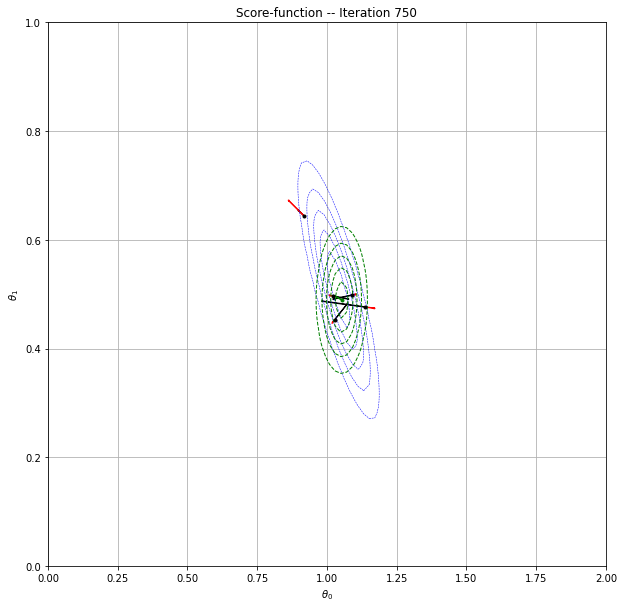

Score-function -- Iteration    750 / 1000, M = 5: q is N( 1.050,  0.050) and N( 0.490,  0.078) -> ELBO =       -407.7207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 766:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 1853.63 (mean) and 434.54 (std).
	- Current lambda: [1.05249286 0.51208469] (mean) and [0.0026043  0.06310645] (std).
Anyway. No harm done -- will just keep on going!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 787:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 249.83 (mean) and 545.14 (std).
	- Current lambda: [1.06092129 0.50743544] (mean) and [0.03048751 0.09278159] (std).
Anyway. No harm done -- will just keep on going!


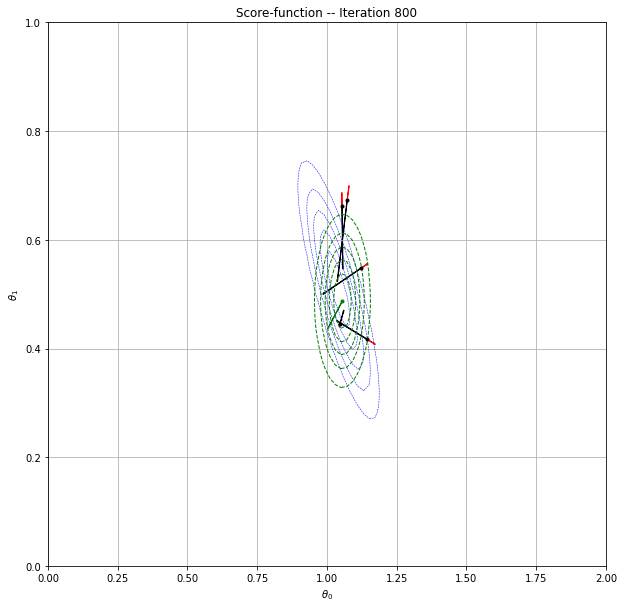

Score-function -- Iteration    800 / 1000, M = 5: q is N( 1.051,  0.054) and N( 0.483,  0.077) -> ELBO =       -406.1484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 803:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 212.43 (mean) and 109.68 (std).
	- Current lambda: [1.07016508 0.4820677 ] (mean) and [0.00908433 0.07967696] (std).
Anyway. No harm done -- will just keep on going!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 828:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 139.77 (mean) and 277.18 (std).
	- Current lambda: [1.14884575 0.40484563] (mean) and [0.01405367 0.04692247] (std).
Anyway. No harm done -- will just keep on going!


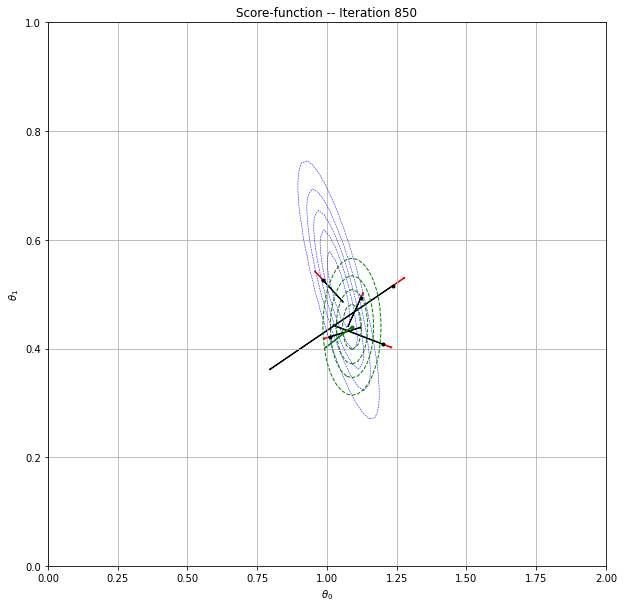

Score-function -- Iteration    850 / 1000, M = 5: q is N( 1.080,  0.033) and N( 0.436,  0.074) -> ELBO =       -411.6510


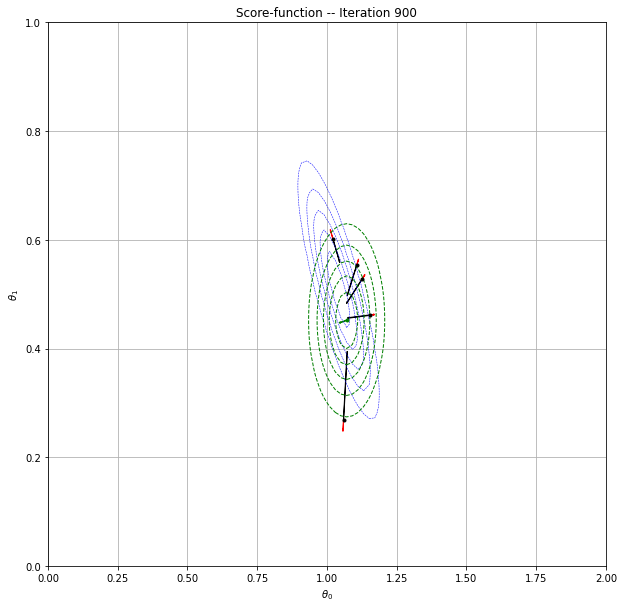

Score-function -- Iteration    900 / 1000, M = 5: q is N( 1.068,  0.076) and N( 0.451,  0.091) -> ELBO =       -411.4283


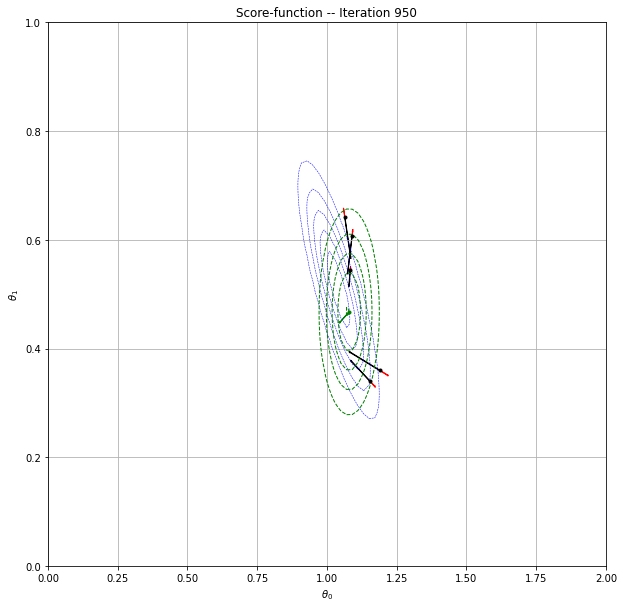

Score-function -- Iteration    950 / 1000, M = 5: q is N( 1.076,  0.061) and N( 0.466,  0.103) -> ELBO =       -419.5332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 977:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 322.23 (mean) and 1127.16 (std).
	- Current lambda: [1.06925433 0.46776718] (mean) and [0.06814825 0.1027685 ] (std).
Anyway. No harm done -- will just keep on going!


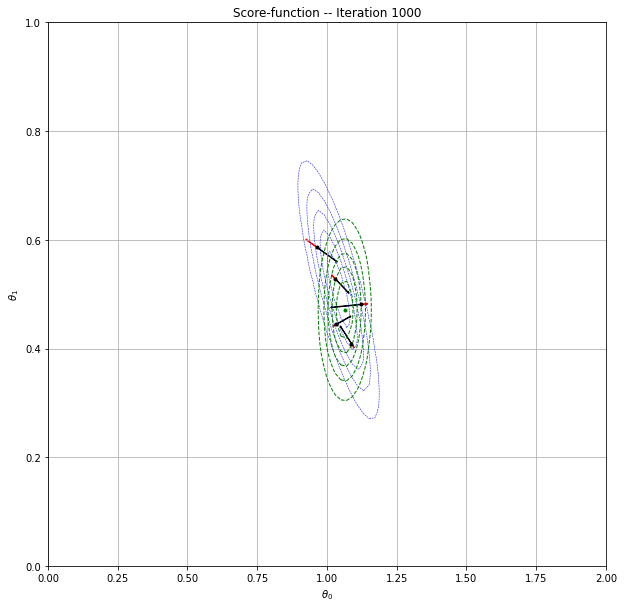

Score-function -- Iteration   1000 / 1000, M = 5: q is N( 1.064,  0.050) and N( 0.471,  0.091) -> ELBO =       -411.8901


In [ ]:
score_function = {'name': 'Score-function', 'callable': score_function_gradient}
compute_gradients(score_function, no_samples_per_iter=5)

# Exercise 2. Reparametrization Gradients

* In this second exercise, we ask you to implement a key part of the reparametrization trick method to compute the gradients of the ELBO. As we showed in Slide 13, the reparametrization trick method computes the gradient of the ELBO in the following way:

$$\nabla_\lambda {\cal L} (\lambda) = \frac{1}{M} \sum_{j}^M ∇_\theta \ln \frac{p(D,\theta^{(j)})}{q(\theta^{(j)}|\lambda)}∇_λ f(ϵ^{(j)},\lambda)$$
where $\epsilon^{(j)} \sim N(0|I)$ and  $\theta^{(j)}=f(\epsilon^{(j)},\lambda)$. 


* Remember, we have a **linear regression model**
$$\theta_0, \theta_1 \sim N(0,10)$$
$$y|x,\theta_0,\theta_1 \sim N(\theta_0 x + \theta_1, 0.1)$$

* In our case, we have **two parameters** $\theta=(\theta_0,\theta_1)$ and the **variational family** $q(\theta|\lambda)$ can be expressed as:

$$q(\theta|\lambda) = q_0(\theta_0|\mu_0,\sigma_0)q_1(\theta_1|\mu_1,\sigma_1)$$

$$q_i(\theta_i|\mu_i,\sigma_i) = N(\theta_i|\mu_i,\sigma_i)\quad i=0,1$$

* In this case, $q_i(\theta_i|\mu_i,\sigma_i)$ is Gaussian. In consequence, 
$$ ϵ∼ N(0,I)$$
$$ \theta_i = \mu_i + ϵ\cdot\sigma_i \quad i=0,1$$


* **For a given sample $\epsilon$ from $\phi(\epsilon)=N(0,I)$** and $\theta = f(ϵ,\lambda) = \mu + \epsilon\sigma$. Then, we have to:

> 1. **Compute the gradient wrt $\theta$** (the  code is given below): 
$$∇_\theta \ln \frac{p(D,\theta)}{q(\theta|\lambda)} = ∇_\theta \ln p(D,\theta) - ∇_\theta \ln q(\theta|\lambda)$$ 


> > - **a)** We first compute $∇_\theta \ln p(\theta)$:


$$∇_{\theta_j} \ln p(\theta_i) = -\frac{\theta_j}{\sigma_p^2}\quad i=0,1$$

> > > where $\sigma_p$ is the standard deviation of the prior $p(\theta) = N(0,\sigma_p)$. 

> > - **b)** Next step is to compute $∇_{\theta} \ln p(D|\theta)$,

$$∇_{\theta_0} \ln p(D|\theta_0,\theta_1) = \sum_{i=1}^n \frac{(y-\theta_0 - \theta_1 x_i)}{\sigma_D^2}$$

$$∇_{\theta_1} \ln p(D|\theta_0,\theta_1) = \sum_{i=1}^n x_i\frac{(y-\theta_0 - \theta_1 x_i)}{\sigma_D^2}$$

> > > where $\sigma^2_D$ is the observation noise. 

> > - **c)** Finally, we compute $∇_{\theta} \ln q(\theta|\lambda)$:

$$∇_{\theta_i} \ln q_i(\theta_i|\mu_i,\sigma_i) = - \frac{(\theta_i - \mu_i)}{\sigma_i^2}\quad j=0,1$$

> 2. **Compute the gradient** $\nabla_\lambda f(ϵ,\lambda)$. 

$$ \nabla_{\mu_i} f(ϵ,\lambda) = 1 \quad i=0,1 $$
$$ \nabla_{\sigma_i} f(ϵ,\lambda) = ϵ \quad i=0,1 $$


* **TASK FOR THIS EXERCISE:** Experiment with the number of Monte-Carlo samples $M$ per iteration, the learning-rate, and the number of iterations. Compare with the output of the Score Function Gradient.


In [ ]:
def reparameterization_gradient(
        q_distribution: Parameters,
        prior: Parameters,
        observation_noise: float,
        data: Dict[str, np.ndarray],
) -> GradientInfo:

    """
    Gradient at theta defined using the re-parameterization-trick
    :param q_distribution: Parameters for the q-distribution
    :param prior: Parameters for the prior distribution
    :param observation_noise: The observation noise in the regression model
    :param data: A dictionary with the data. Has two keys: 'x' and 'y'
    :return: The gradient info. 
    """

    # Sample a location -- now from Normal(0, I)
    epsilon_sample = multivariate_normal(mean=np.array([0, 0]), cov=np.identity(n=2)).rvs(size=1)

    # Translate back: theta = mu + epsilon * sigma, with product being element-wise
    theta_sample = q_distribution.mean + np.multiply(epsilon_sample, q_distribution.std)

    # Compute \nabla_\lambda log p(\theta) = \nabla_\theta log p(\theta) \nabla_\lambda f(\epsilon,\lambda)  \:
    #       For mu_j it is -theta_j/sigma_prior^2,
    #       For sigma_j it is -theta_j/sigma_prior^2 * epsilon_j
    gradient = Parameters(
        mean=-1 * theta_sample / prior.std ** 2,
        std=-1 * np.multiply(theta_sample / prior.std ** 2, epsilon_sample)
    )

    # Gradient of  \nabla_\lambda log p(Data|theta) = \nabla_\theta log p(Data|\theta) \nabla_\lambda f(\epsilon,\lambda):
    #   For mu_0 it is sum_i (y_i - theta_0 - theta_i * x_i) / sigma_data**2
    #   For mu_1 it is sum_i (y_i - theta_0 - theta_i * x_i) * x_i / sigma_data**2
    #   For sigma_0 it is sum_i (y_i - theta_0 - theta_1 * x_i) * epsilon_0 / sigma_data**2 + 1/sigma_0^2
    #   For sigma_1 it is sum_i (y_i - theta_0 - theta_1 * x_i) * x_i * epsilon_1 / sigma_data**2 + 1/sigma_1^2

    for i in range(data['x'].shape[0]):
        x_i = data['x'][i]
        y_i = data['y'][i]
        error_i = (y_i - theta_sample[0] - theta_sample[1]*x_i) / (observation_noise ** 2)
        delta_mean = np.array([error_i, error_i * x_i])
        delta_std = np.multiply(delta_mean, epsilon_sample)

        gradient.mean += delta_mean
        gradient.std += delta_std

    # Gradient of \nabla_\lambda log q(theta|lambda) = \nabla_\theta log q(theta|lambda) \nabla_\lambda f(\epsilon,\lambda)
    gradient.mean -= -(theta_sample - q_distribution.mean)/q_distribution.std**2
    gradient.std -=  -np.multiply((theta_sample - q_distribution.mean)/q_distribution.std**2, epsilon_sample)

    # Put everything into the data-structure and leave
    solution = GradientInfo(
        theta=theta_sample,
        score_function=None,
        gradient=gradient,
        aggregation=False)

    return solution


Since `reparameterization_gradient` works as is, just put it into the dict and run.

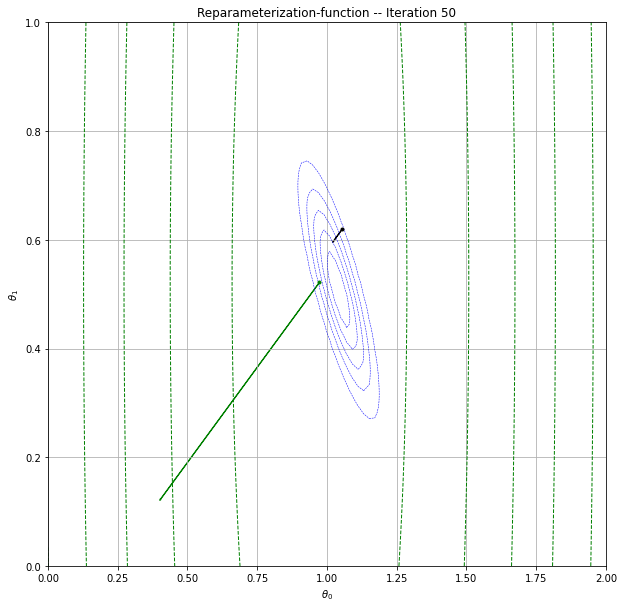

Reparameterization-function -- Iteration     50 / 1000, M = 5: q is N( 0.916,  1.027) and N( 0.482,  4.214) -> ELBO =      -2525.2554


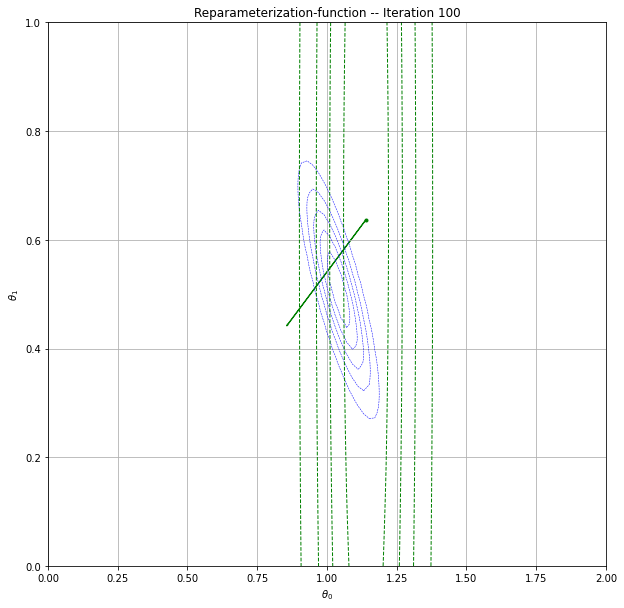

Reparameterization-function -- Iteration    100 / 1000, M = 5: q is N( 1.112,  0.106) and N( 0.618,  1.613) -> ELBO =       -739.5307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: 
Had to undo move in iteration 116:
	- Learning rate: 0.0001
	- M = 5
	- Gradient lengths 197.90 (mean) and 756.69 (std).
	- Current lambda: [1.12085681 0.63358415] (mean) and [0.01457349 1.28244476] (std).
Anyway. No harm done -- will just keep on going!


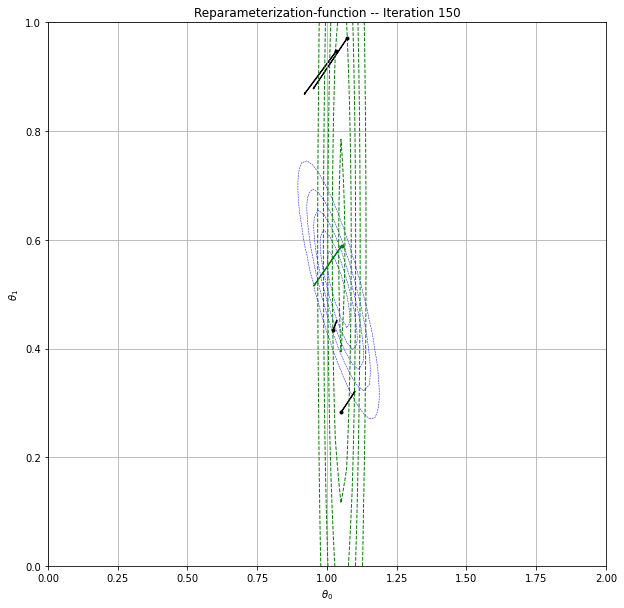

Reparameterization-function -- Iteration    150 / 1000, M = 5: q is N( 1.043,  0.038) and N( 0.582,  0.633) -> ELBO =       -465.8293


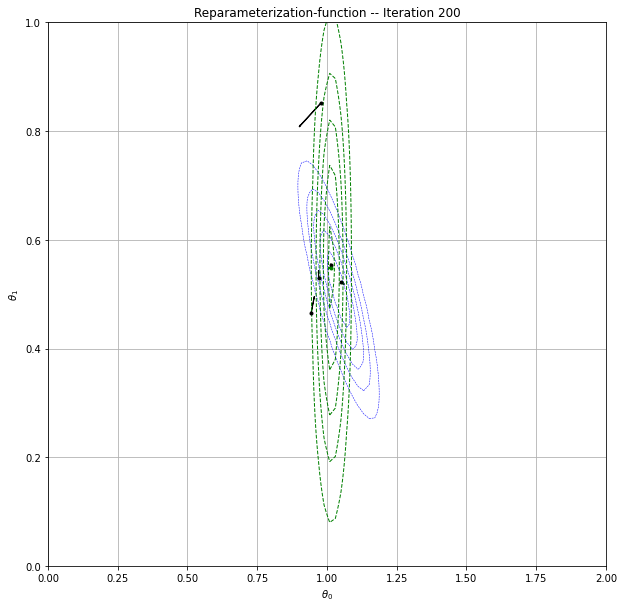

Reparameterization-function -- Iteration    200 / 1000, M = 5: q is N( 1.015,  0.040) and N( 0.549,  0.257) -> ELBO =       -406.3843


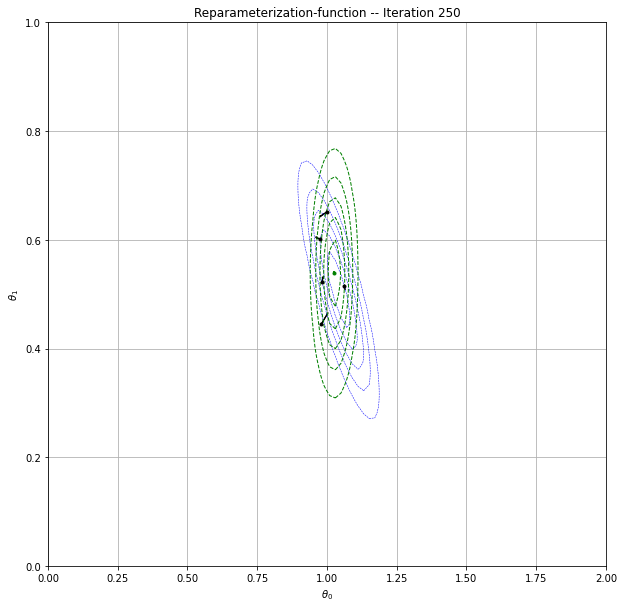

Reparameterization-function -- Iteration    250 / 1000, M = 5: q is N( 1.027,  0.046) and N( 0.539,  0.123) -> ELBO =       -405.8966


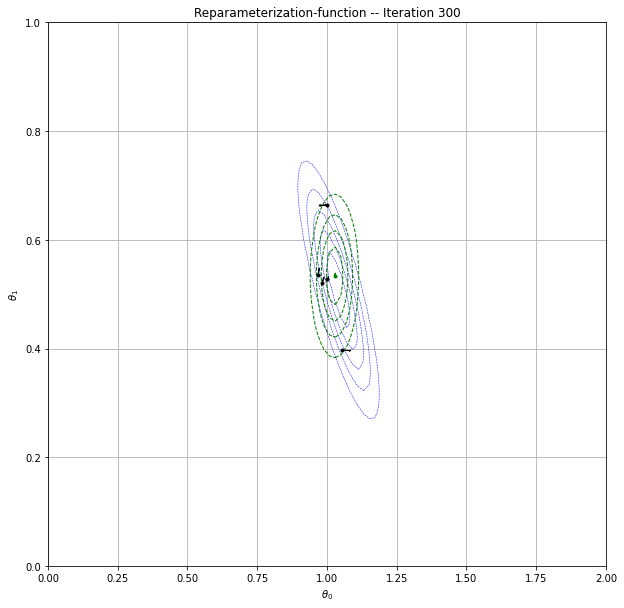

Reparameterization-function -- Iteration    300 / 1000, M = 5: q is N( 1.028,  0.049) and N( 0.534,  0.085) -> ELBO =       -404.6141


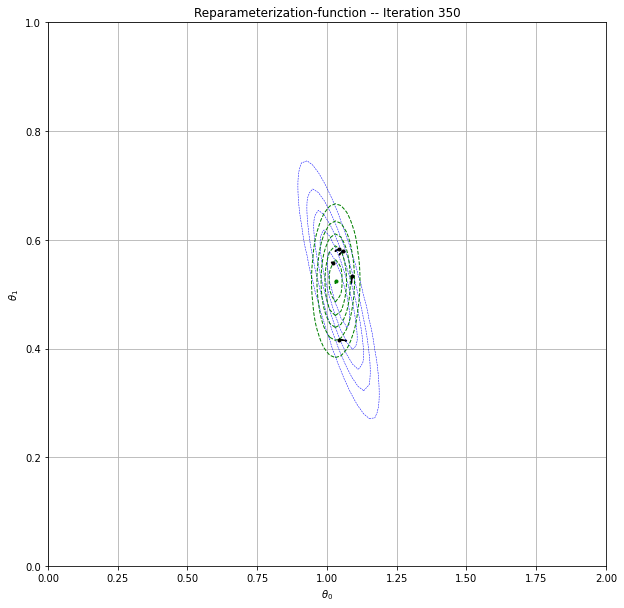

Reparameterization-function -- Iteration    350 / 1000, M = 5: q is N( 1.031,  0.046) and N( 0.524,  0.076) -> ELBO =       -403.9319


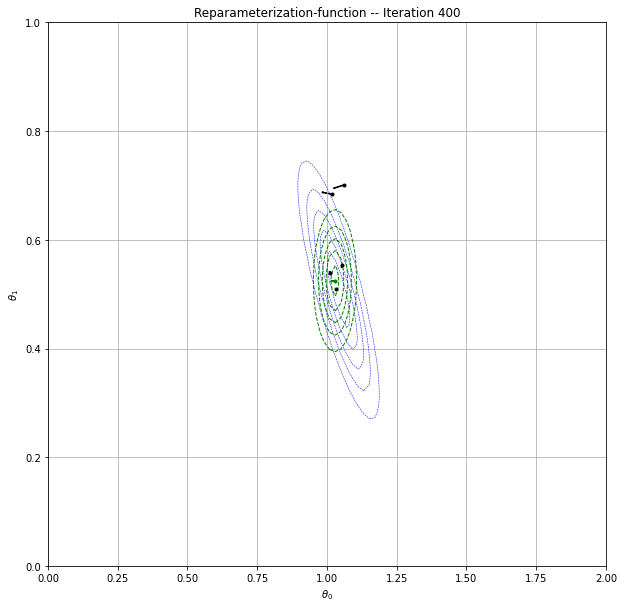

Reparameterization-function -- Iteration    400 / 1000, M = 5: q is N( 1.027,  0.041) and N( 0.525,  0.071) -> ELBO =       -400.9511


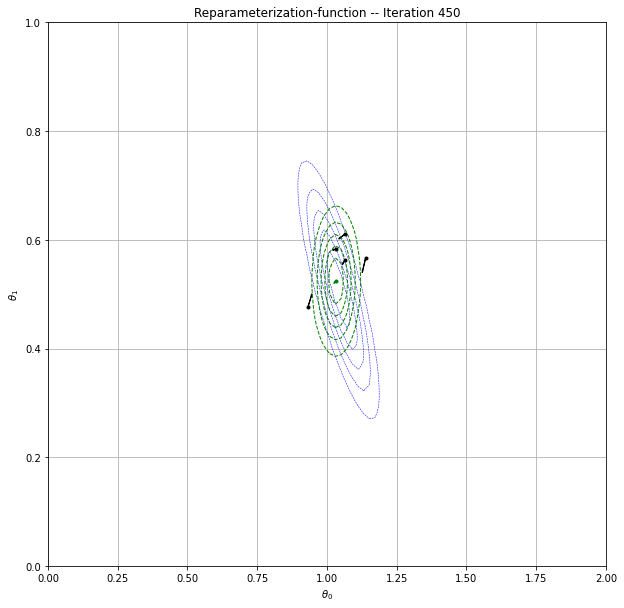

Reparameterization-function -- Iteration    450 / 1000, M = 5: q is N( 1.032,  0.044) and N( 0.524,  0.072) -> ELBO =       -404.1332


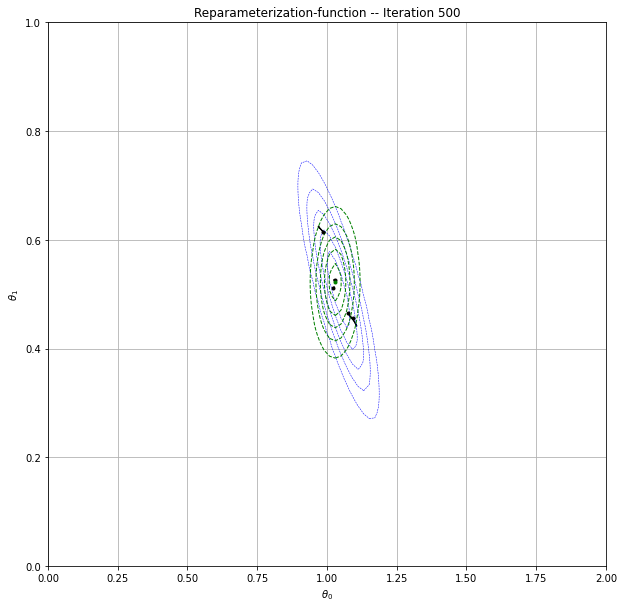

Reparameterization-function -- Iteration    500 / 1000, M = 5: q is N( 1.030,  0.049) and N( 0.522,  0.076) -> ELBO =       -402.4879


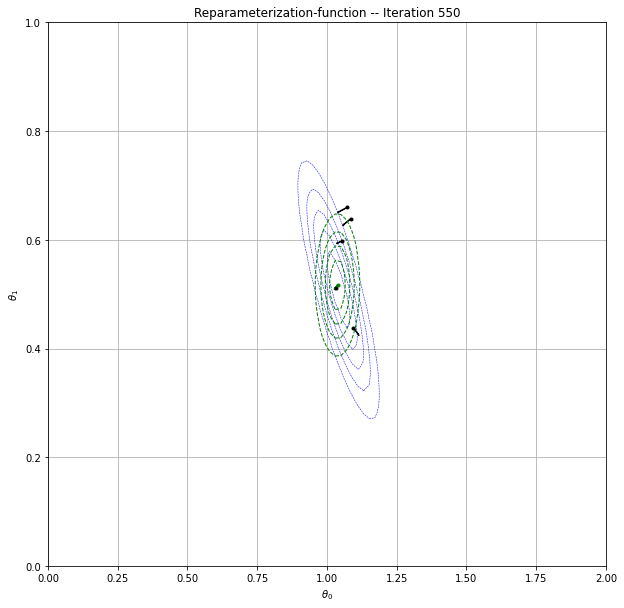

Reparameterization-function -- Iteration    550 / 1000, M = 5: q is N( 1.037,  0.043) and N( 0.516,  0.073) -> ELBO =       -405.0992


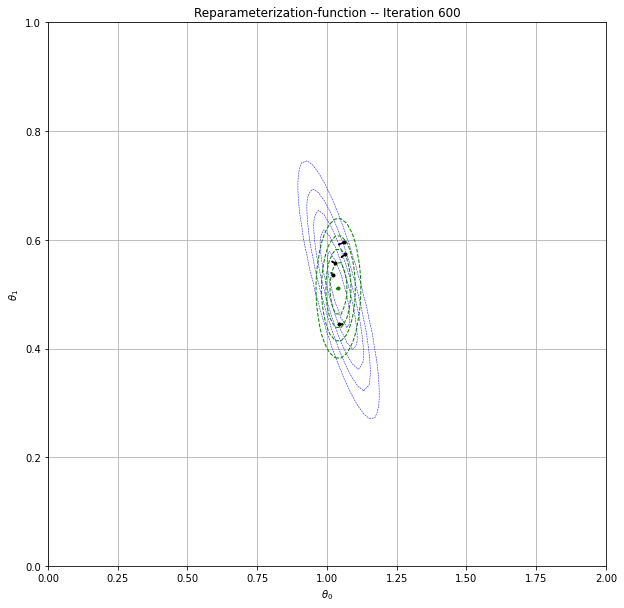

Reparameterization-function -- Iteration    600 / 1000, M = 5: q is N( 1.041,  0.043) and N( 0.511,  0.071) -> ELBO =       -405.9579


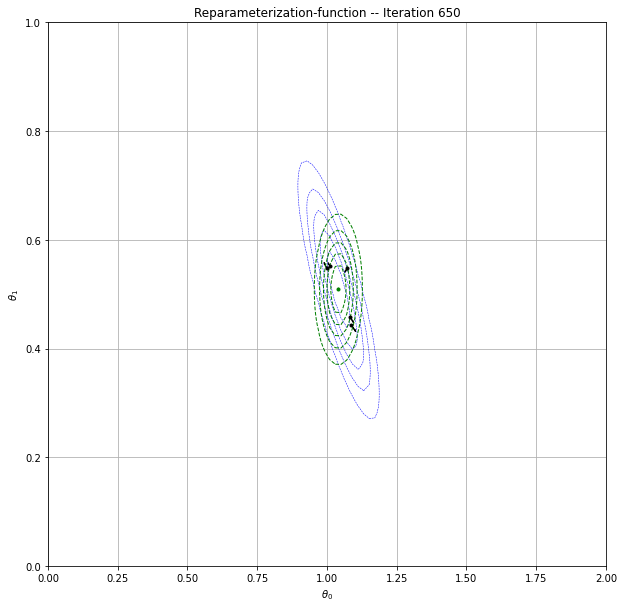

Reparameterization-function -- Iteration    650 / 1000, M = 5: q is N( 1.041,  0.045) and N( 0.509,  0.074) -> ELBO =       -406.1423


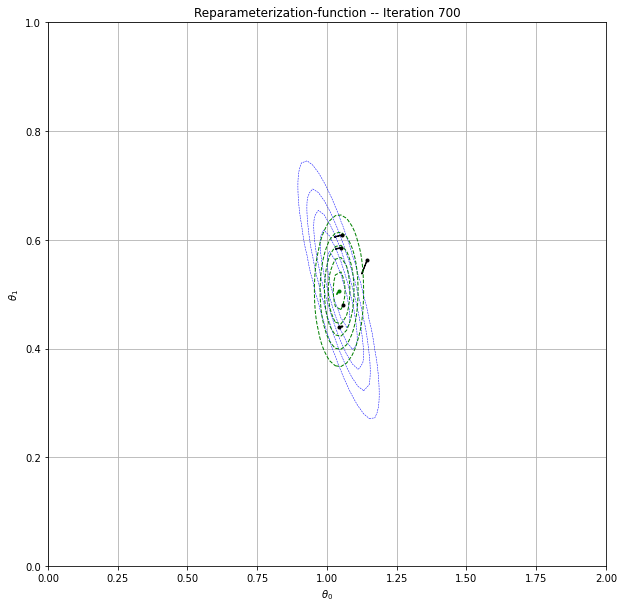

Reparameterization-function -- Iteration    700 / 1000, M = 5: q is N( 1.043,  0.046) and N( 0.506,  0.075) -> ELBO =       -406.6483


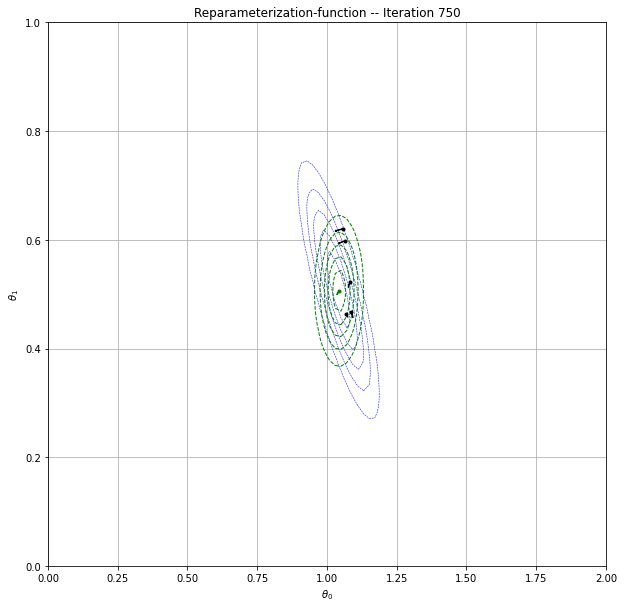

Reparameterization-function -- Iteration    750 / 1000, M = 5: q is N( 1.043,  0.046) and N( 0.506,  0.074) -> ELBO =       -406.6610


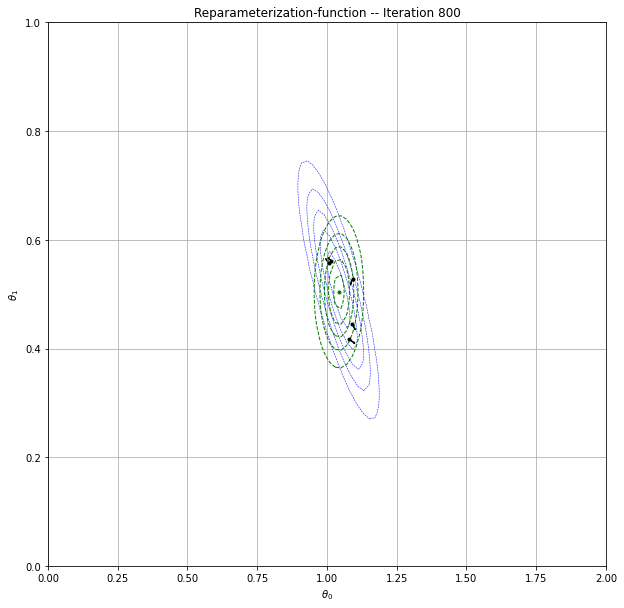

Reparameterization-function -- Iteration    800 / 1000, M = 5: q is N( 1.044,  0.048) and N( 0.504,  0.076) -> ELBO =       -406.7293


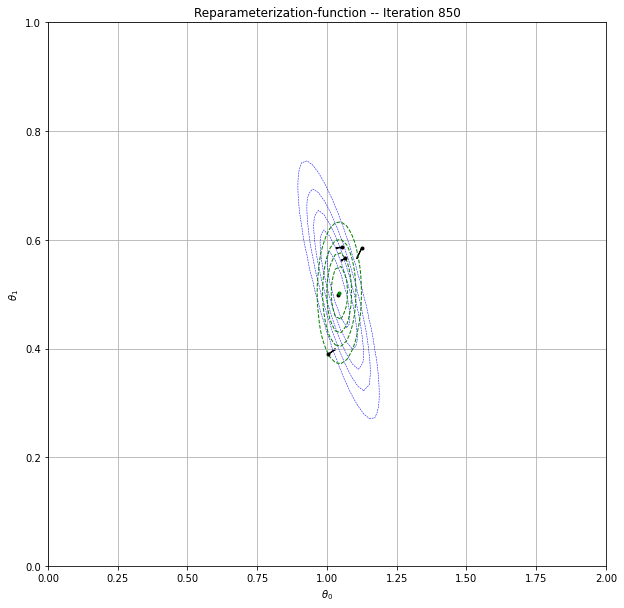

Reparameterization-function -- Iteration    850 / 1000, M = 5: q is N( 1.044,  0.042) and N( 0.502,  0.072) -> ELBO =       -405.8520


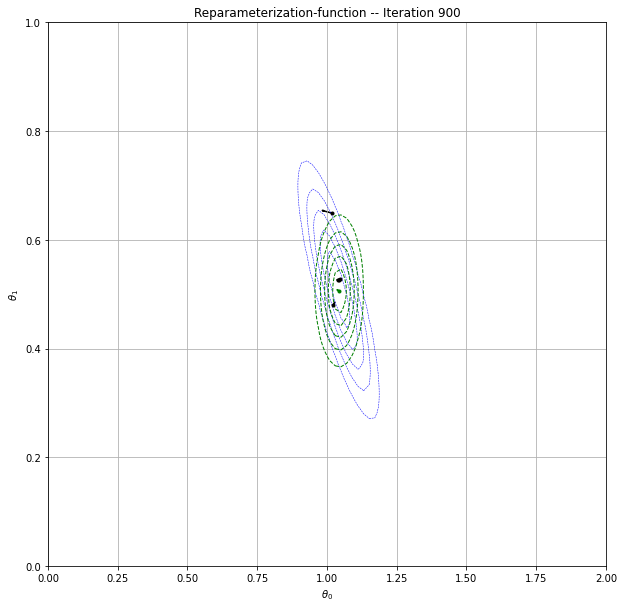

Reparameterization-function -- Iteration    900 / 1000, M = 5: q is N( 1.044,  0.046) and N( 0.506,  0.075) -> ELBO =       -407.2872


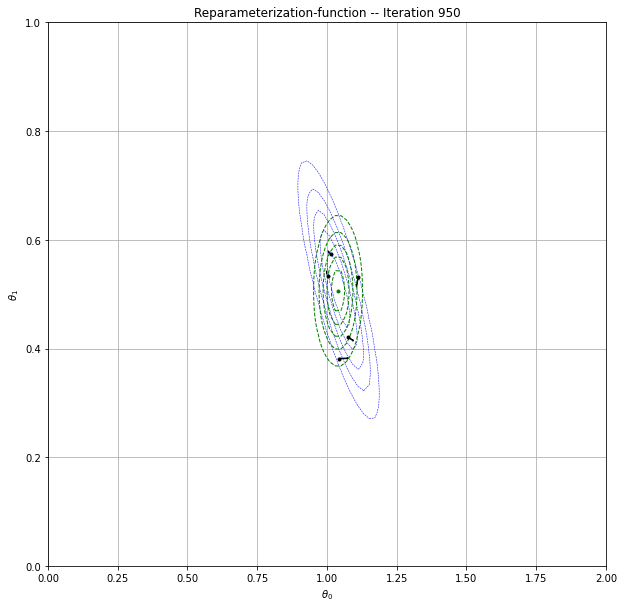

Reparameterization-function -- Iteration    950 / 1000, M = 5: q is N( 1.041,  0.047) and N( 0.506,  0.074) -> ELBO =       -405.1032


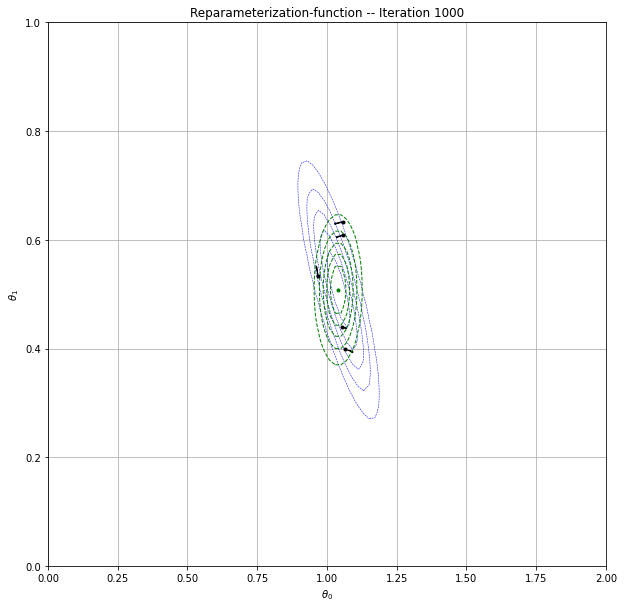

Reparameterization-function -- Iteration   1000 / 1000, M = 5: q is N( 1.040,  0.045) and N( 0.508,  0.073) -> ELBO =       -405.2329


In [ ]:
reparametrization_trick = {'name': 'Reparameterization-function', 'callable': reparameterization_gradient}

compute_gradients(reparametrization_trick, no_samples_per_iter=5)

# Plot the evolution of the ELBO

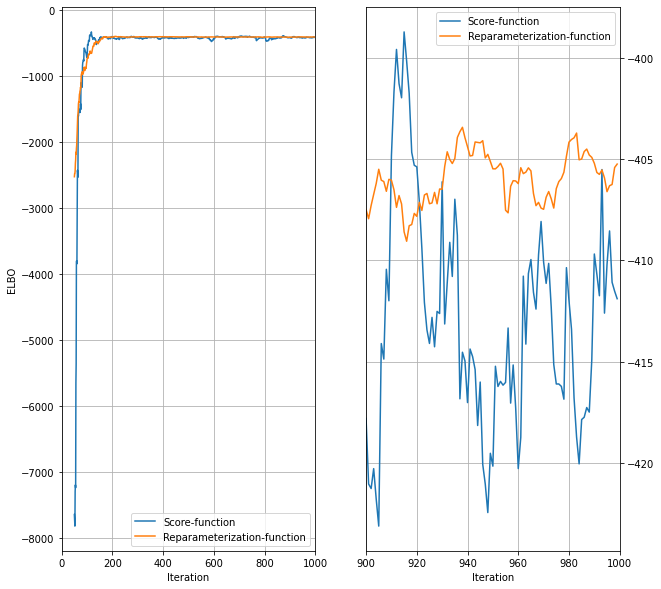

In [ ]:
gradient_methods = [
    {'name': 'Score-function', 'callable': score_function_gradient,},
    {'name': 'Reparameterization-function', 'callable': reparameterization_gradient, },
]

no_iter=1000
# Plot ELBO -- overall and last 10%
_, axes = plt.subplots(1, 2)
init=50
for gradient_method in gradient_methods:
    axes[0].plot(range(init, 1 + no_iter),
                  store_elbo[gradient_method['name']][(init-1):],
                  label=gradient_method['name'])
    axes[0].set_xlim(0, no_iter)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("ELBO")
    axes[0].grid(True, which="both")

    axes[1].yaxis.tick_right()
    axes[1].plot(range(int(no_iter * .9), no_iter),
                  store_elbo[gradient_method['name']][int(no_iter * .9):],
                  label=gradient_method['name'])
    axes[1].set_xlim(int(no_iter * .9), no_iter)
    axes[1].set_xlabel("Iteration")
    axes[1].grid(True, which="both")

axes[0].legend()
axes[1].legend()
plt.savefig("elbo.pdf")
plt.show()